<a href="https://colab.research.google.com/github/ThamilezaiAnanthakumar/Cuffless-Blood-Pressure-Monitoring-using-PAT/blob/main/Cufless_Blood_Pressure_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mkachuee/BloodPressureDataset")

print("Path to dataset files:", path)

100%|██████████| 4.60G/4.60G [00:53<00:00, 91.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mkachuee/BloodPressureDataset/versions/5


In [28]:
import os
path= '/root/.cache/kagglehub/datasets/mkachuee/BloodPressureDataset/versions/5/Samples'
# List the contents of the downloaded directory
print(os.listdir(path))

['rec_96.csv', 'rec_226.csv', 'rec_347.csv', 'rec_394.csv', 'rec_434.csv', 'rec_198.csv', 'rec_178.csv', 'rec_127.csv', 'rec_426.csv', 'rec_377.csv', 'rec_150.csv', 'rec_258.csv', 'rec_68.csv', 'rec_238.csv', 'rec_56.csv', 'rec_435.csv', 'rec_197.csv', 'rec_319.csv', 'rec_438.csv', 'rec_413.csv', 'rec_192.csv', 'rec_382.csv', 'rec_116.csv', 'rec_490.csv', 'rec_444.csv', 'rec_383.csv', 'rec_102.csv', 'rec_215.csv', 'rec_293.csv', 'rec_247.csv', 'rec_190.csv', 'rec_106.csv', 'rec_277.csv', 'rec_36.csv', 'rec_169.csv', 'rec_254.csv', 'rec_273.csv', 'rec_406.csv', 'rec_13.csv', 'rec_437.csv', 'rec_392.csv', 'rec_38.csv', 'rec_324.csv', 'rec_65.csv', 'rec_340.csv', 'rec_398.csv', 'rec_380.csv', 'rec_6.csv', 'rec_43.csv', 'rec_399.csv', 'rec_186.csv', 'rec_24.csv', 'rec_72.csv', 'rec_312.csv', 'rec_463.csv', 'rec_1.csv', 'rec_300.csv', 'rec_85.csv', 'rec_486.csv', 'rec_19.csv', 'rec_208.csv', 'rec_18.csv', 'rec_389.csv', 'rec_311.csv', 'rec_249.csv', 'rec_84.csv', 'rec_25.csv', 'rec_99.csv',

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
from scipy.signal import find_peaks

In [ ]:
sampling_frequency = 125

def find_ppg_onsets(ppg_cleaned, peaks, sampling_rate=125, window_sec=0.5):
    onsets = []
    window = int(window_sec * sampling_rate)
    for peak in peaks:
        start = max(0, peak - window)
        segment = ppg_cleaned[start:peak]
        diff = np.gradient(segment)
        foot_index = np.argmin(diff)
        onset_index = start + foot_index
        onsets.append(onset_index)
    return onsets

In [ ]:
full_data=[]
for i in range(len(os.listdir(path))):
  csv_file_path = os.path.join(path, 'rec_96.csv')
  # Read the CSV without a header
  df = pd.read_csv(csv_file_path, header=None)
  df.head()


  waveform_row1 = df.iloc[0].values
  waveform_row2 = df.iloc[1].values
  waveform_row3 = df.iloc[2].values

  ppg = waveform_row1
  abp = waveform_row2
  ecg = waveform_row3

  signals, info = nk.ecg_process(ecg, sampling_rate=125)
  r_peaks = info["ECG_R_Peaks"]


  _, ppg_info = nk.ppg_process(ppg, sampling_rate=125)
  ppg_peaks = ppg_info["PPG_Peaks"]


  systolic_peaks, _ = find_peaks(abp, distance=50)  # systolic (local maxima)
  diastolic_peaks, _ = find_peaks(-abp, distance=50)  # diastolic (local minima)

  systolic_values = abp[systolic_peaks]
  diastolic_values = abp[diastolic_peaks]

  onsets = find_ppg_onsets(ppg, r_peaks)


  PATs = []
  PAT_times = []
  for r in r_peaks:
      future_foots = ppg_peaks[ppg_peaks > r]
      if len(future_foots) == 0:
          continue
      ppg_foot = future_foots[0]
      pat = (ppg_foot - r) / sampling_rate  # in seconds
      PATs.append(pat)
      PAT_times.append(r / sampling_rate)



  # Ensure lengths match
  min_len = min(len(PATs), len(systolic_values), len(diastolic_values))
  data = {
      "PAT (s)": np.mean(PATs[:min_len]),
      "Systolic BP": np.mean(systolic_values[:min_len]),
      "Diastolic BP": np.mean(diastolic_values[:min_len])
  }

  full_data.append(data)
  df=pd.dataframe(full_data)
  df.head()


In [6]:
csv_file_path = os.path.join(path, 'rec_96.csv')
# Read the CSV without a header
df = pd.read_csv(csv_file_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,71990,71991,71992,71993,71994,71995,71996,71997,71998,71999
0,1.41150,1.56790,1.74100,1.92180,2.09970,2.26880,2.42230,2.55720,2.65690,2.73220,...,0.96872,0.98045,1.00680,1.05470,1.12810,1.22970,1.35870,1.51120,1.67840,1.85240
1,115.91000,111.76000,108.87000,107.26000,106.43000,106.24000,106.43000,106.97000,107.60000,108.09000,...,154.10000,148.19000,141.35000,133.93000,126.51000,119.91000,115.08000,112.10000,110.83000,110.49000
2,0.47507,0.47019,0.47019,0.46481,0.47019,0.47019,0.47019,0.47507,0.47507,0.47507,...,0.49022,0.49022,0.49022,0.48485,0.48485,0.48485,0.48485,0.49022,0.49022,0.47996


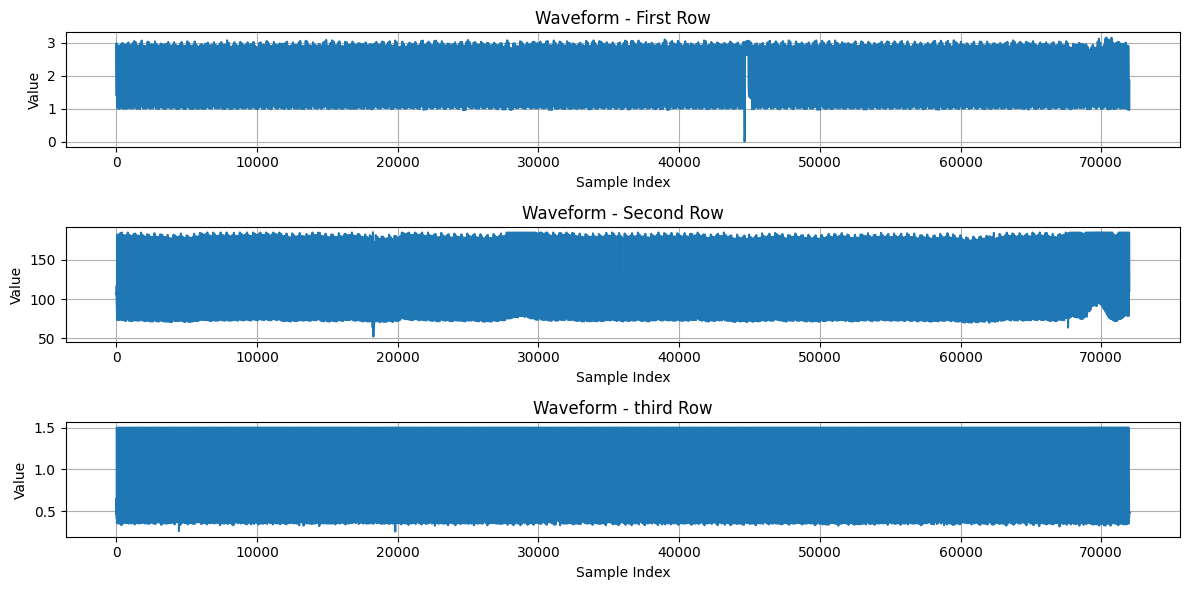

In [7]:
# prompt: plot and first and second row as wave form

import matplotlib.pyplot as plt

# Extract the first and second row as arrays
waveform_row1 = df.iloc[0].values
waveform_row2 = df.iloc[1].values
waveform_row3 = df.iloc[2].values

ppg = waveform_row1
abp = waveform_row2
ecg = waveform_row3

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 6))

# Plot the first row
axes[0].plot(waveform_row1)
axes[0].set_title('Waveform - First Row')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Value')
axes[0].grid(True)

# Plot the second row
axes[1].plot(waveform_row2)
axes[1].set_title('Waveform - Second Row')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Value')
axes[1].grid(True)


# Plot the third row
axes[2].plot(waveform_row3)
axes[2].set_title('Waveform - third Row')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Value')
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


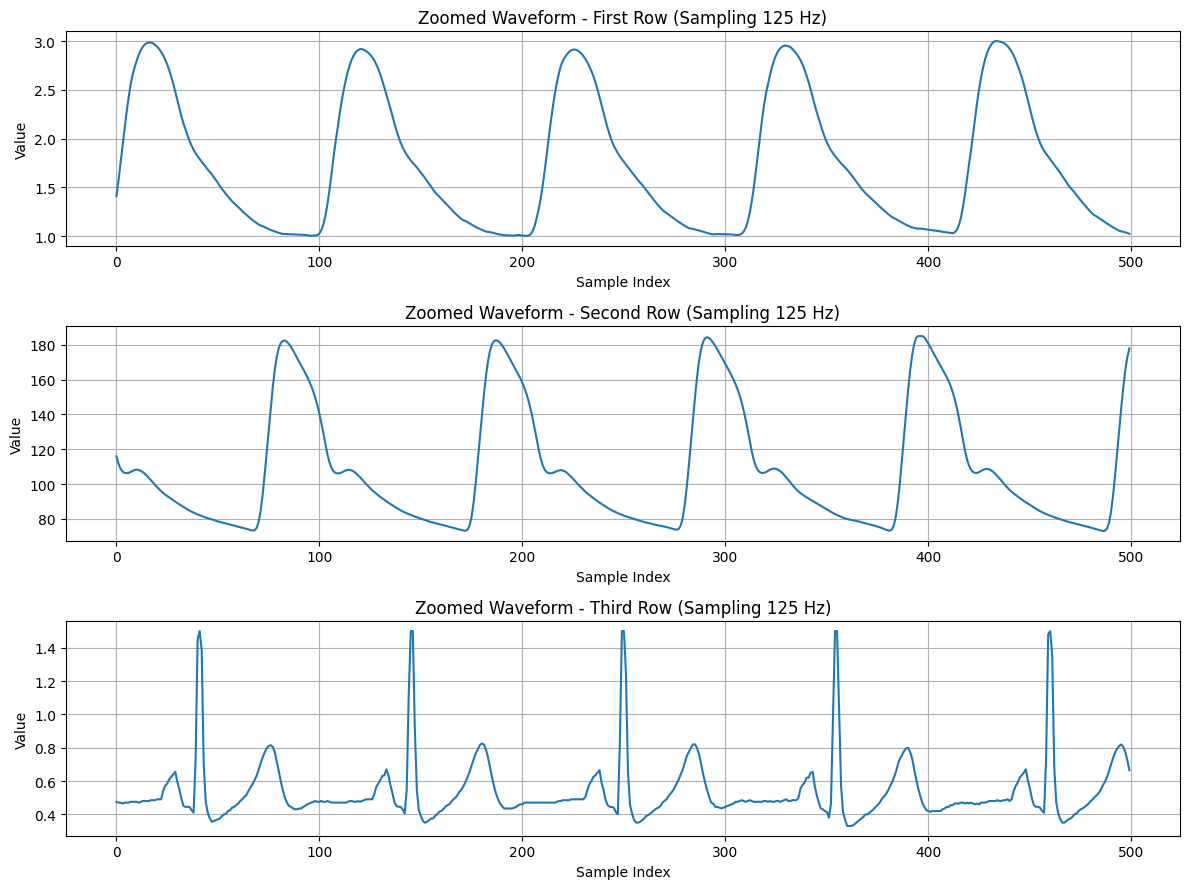

In [8]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Plot the first row with zooming
zoom_start = 0  # Start index for zooming
zoom_end = 500  # End index for zooming

axes[0].plot(waveform_row1[zoom_start:zoom_end])
axes[0].set_title('Zoomed Waveform - First Row (Sampling 125 Hz)')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Value')
axes[0].grid(True)

# Plot the second row with zooming
axes[1].plot(waveform_row2[zoom_start:zoom_end])
axes[1].set_title('Zoomed Waveform - Second Row (Sampling 125 Hz)')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Value')
axes[1].grid(True)

# Plot the third row with zooming
axes[2].plot(waveform_row3[zoom_start:zoom_end])
axes[2].set_title('Zoomed Waveform - Third Row (Sampling 125 Hz)')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Value')
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
!pip install neurokit2

In [11]:
import neurokit2 as nk
import numpy as np
from scipy.signal import find_peaks


sampling_rate = 125

signals, info = nk.ecg_process(ecg, sampling_rate=125)
r_peaks = info["ECG_R_Peaks"]


_, ppg_info = nk.ppg_process(ppg, sampling_rate=125)
ppg_peaks = ppg_info["PPG_Peaks"]


systolic_peaks, _ = find_peaks(abp, distance=50)  # systolic (local maxima)
diastolic_peaks, _ = find_peaks(-abp, distance=50)  # diastolic (local minima)

systolic_values = abp[systolic_peaks]
diastolic_values = abp[diastolic_peaks]



In [17]:
print(systolic_values)
print(diastolic_values)

[108.29  182.43  182.63  184.39  185.02  181.94  181.26  181.5   185.02
 182.24  180.82  180.58  183.17  183.75  181.31  181.02  180.72  184.87
 181.9   180.43  179.7   182.68  182.48  180.14  179.31  179.45  184.14
 180.38  179.5   179.06  182.63  182.38  180.19  179.16  178.92  182.04
 178.18  177.35  177.94  182.19  181.16  179.75  179.5   179.99  183.75
 180.04  178.38  177.69  181.5   180.14  178.38  178.04  179.45  183.36
 180.04  179.89  180.14  184.58  183.85  182.43  182.38  182.82  185.02
 181.7   180.87  180.67  184.92  182.73  180.87  180.92  181.55  185.02
 181.8   181.46  180.58  185.02  182.38  180.38  180.14  181.94  184.73
 181.02  180.92  180.38  185.02  183.26  181.5   181.46  182.92  185.02
 181.75  180.72  180.63  185.02  183.8   182.38  181.6   183.26  185.02
 182.24  181.9   181.99  185.02  183.7   182.19  180.92  182.68  185.02
 183.36  182.73  182.19  185.02  183.7   181.36  180.23  180.82  183.75
 180.04  178.87  179.11  183.85  181.6   180.04  179.94  180.63 

In [13]:
def find_ppg_onsets(ppg_cleaned, peaks, sampling_rate=125, window_sec=0.5):
    onsets = []
    window = int(window_sec * sampling_rate)
    for peak in peaks:
        start = max(0, peak - window)
        segment = ppg_cleaned[start:peak]
        diff = np.gradient(segment)
        foot_index = np.argmin(diff)
        onset_index = start + foot_index
        onsets.append(onset_index)
    return onsets


In [14]:
onsets = find_ppg_onsets(ppg, r_peaks)

[{'PAT (s)': np.float64(0.6424457142857143), 'Systolic BP': np.float64(180.55996857142858), 'Diastolic BP': np.float64(73.55032428571428)}]
    PAT (s)  Systolic BP  Diastolic BP
0  0.642446   180.559969     73.550324


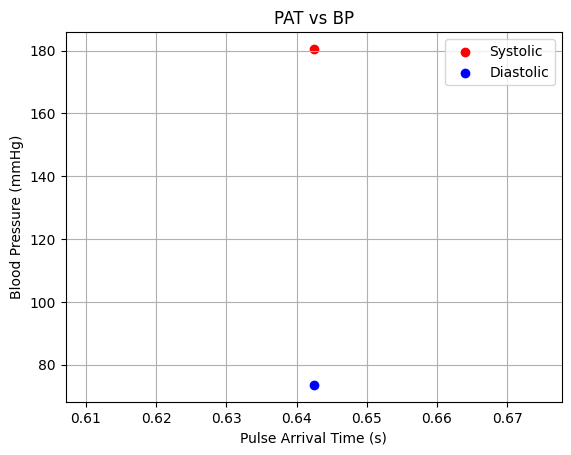

In [30]:
# Match each R-peak to the  next PPG foot (to compute PAT)
PATs = []
PAT_times = []
for r in r_peaks:
    future_foots = ppg_peaks[ppg_peaks > r]
    if len(future_foots) == 0:
        continue
    ppg_foot = future_foots[0]
    pat = (ppg_foot - r) / sampling_rate  # in seconds
    PATs.append(pat)
    PAT_times.append(r / sampling_rate)



# Ensure lengths match
min_len = min(len(PATs), len(systolic_values), len(diastolic_values))
data = {
    "PAT (s)": np.mean(PATs[:min_len]),
    "Systolic BP": np.mean(systolic_values[:min_len]),
    "Diastolic BP": np.mean(diastolic_values[:min_len])
}

print(([data]))

df = pd.DataFrame([data])
print(df.head())


plt.scatter(df["PAT (s)"], df["Systolic BP"], label="Systolic", color='r')
plt.scatter(df["PAT (s)"], df["Diastolic BP"], label="Diastolic", color='b')
plt.xlabel("Pulse Arrival Time (s)")
plt.ylabel("Blood Pressure (mmHg)")
plt.title("PAT vs BP")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
pip install modin[ray]  # for Ray backend (fastest for most use cases)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.4 MB/s eta 0:00:00


In [ ]:
import modin.pandas as pd

full_data=[]
for i in range(len(os.listdir(path))):
  csv_file_path = os.path.join(path, 'rec_96.csv')
  # Read the CSV without a header
  df = pd.read_csv(csv_file_path, header=None)
  df.head()


  waveform_row1 = df.iloc[0].values
  waveform_row2 = df.iloc[1].values
  waveform_row3 = df.iloc[2].values

  ppg = waveform_row1
  abp = waveform_row2
  ecg = waveform_row3

  signals, info = nk.ecg_process(ecg, sampling_rate=125)
  r_peaks = info["ECG_R_Peaks"]


  _, ppg_info = nk.ppg_process(ppg, sampling_rate=125)
  ppg_peaks = ppg_info["PPG_Peaks"]


  systolic_peaks, _ = find_peaks(abp, distance=50)  # systolic (local maxima)
  diastolic_peaks, _ = find_peaks(-abp, distance=50)  # diastolic (local minima)

  systolic_values = abp[systolic_peaks]
  diastolic_values = abp[diastolic_peaks]

  onsets = find_ppg_onsets(ppg, r_peaks)


  PATs = []
  PAT_times = []
  for r in r_peaks:
      future_foots = ppg_peaks[ppg_peaks > r]
      if len(future_foots) == 0:
          continue
      ppg_foot = future_foots[0]
      pat = (ppg_foot - r) / sampling_rate  # in seconds
      PATs.append(pat)
      PAT_times.append(r / sampling_rate)



  # Ensure lengths match
  min_len = min(len(PATs), len(systolic_values), len(diastolic_values))
  data = {
      "PAT (s)": np.mean(PATs[:min_len]),
      "Systolic BP": np.mean(systolic_values[:min_len]),
      "Diastolic BP": np.mean(diastolic_values[:min_len])
  }

  full_data.append(data)
  df=pd.DataFrame(full_data)
  df.head()


In [ ]:
from concurrent.futures import ProcessPoolExecutor
import modin.pandas as pd
def process_file(file_name):
    csv_file_path = os.path.join(path, file_name)
    df = pd.read_csv(csv_file_path, header=None)

    waveform_row1 = df.iloc[0].values
    waveform_row2 = df.iloc[1].values
    waveform_row3 = df.iloc[2].values

    ppg = waveform_row1
    abp = waveform_row2
    ecg = waveform_row3

    try:
        signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        _, ppg_info = nk.ppg_process(ppg, sampling_rate=sampling_rate)
        ppg_peaks = ppg_info["PPG_Peaks"]

        systolic_peaks, _ = find_peaks(abp, distance=50)
        diastolic_peaks, _ = find_peaks(-abp, distance=50)

        systolic_values = abp[systolic_peaks]
        diastolic_values = abp[diastolic_peaks]

        PATs = []
        for r in r_peaks:
            future_foots = ppg_peaks[ppg_peaks > r]
            if len(future_foots) == 0:
                continue
            ppg_foot = future_foots[0]
            pat = (ppg_foot - r) / sampling_rate
            PATs.append(pat)

        min_len = min(len(PATs), len(systolic_values), len(diastolic_values))
        if min_len == 0:
            return None  # Skip bad data

        return {
            "PAT (s)": np.mean(PATs[:min_len]),
            "Systolic BP": np.mean(systolic_values[:min_len]),
            "Diastolic BP": np.mean(diastolic_values[:min_len])
        }

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return None

# Get list of all CSVs
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

# Parallel processing
full_data = []
with ProcessPoolExecutor() as executor:
    results = executor.map(process_file, csv_files)

    for result in results:
        if result is not None:
            full_data.append(result)

# Convert to DataFrame
df = pd.DataFrame(full_data)
print(df.head())


In [ ]:
from concurrent.futures import ProcessPoolExecutor
import modin.pandas as pd

def process_file(file_name):
    csv_file_path = os.path.join(path, file_name)
    df = pd.read_csv(csv_file_path, header=None)

    waveform_row1 = df.iloc[0].values
    waveform_row2 = df.iloc[1].values
    waveform_row3 = df.iloc[2].values

    ppg = waveform_row1
    abp = waveform_row2
    ecg = waveform_row3

    try:
        signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        _, ppg_info = nk.ppg_process(ppg, sampling_rate=sampling_rate)
        ppg_peaks = ppg_info["PPG_Peaks"]

        systolic_peaks, _ = find_peaks(abp, distance=50)
        diastolic_peaks, _ = find_peaks(-abp, distance=50)

        systolic_values = abp[systolic_peaks]
        diastolic_values = abp[diastolic_peaks]

        PATs = []
        for r in r_peaks:
            future_foots = ppg_peaks[ppg_peaks > r]
            if len(future_foots) == 0:
                continue
            ppg_foot = future_foots[0]
            pat = (ppg_foot - r) / sampling_rate
            PATs.append(pat)

        min_len = min(len(PATs), len(systolic_values), len(diastolic_values))
        if min_len == 0:
            return None  # Skip bad data

        return {
            "PAT (s)": (PATs[:min_len]),
            "Systolic BP": np.mean(systolic_values[:min_len]),
            "Diastolic BP": np.mean(diastolic_values[:min_len])
        }

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return None

# Get list of all CSVs
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

# Parallel processing
full_data = []
with ProcessPoolExecutor() as executor:
    results = executor.map(process_file, csv_files)

    full_data = [r for r in results if r is not None]

# Convert to DataFrame
df = pd.DataFrame(full_data)
print(df.head())


In [ ]:
df.shape

In [37]:
df.isna().sum()

,0
PAT (s),0
Systolic BP,0
Diastolic BP,0


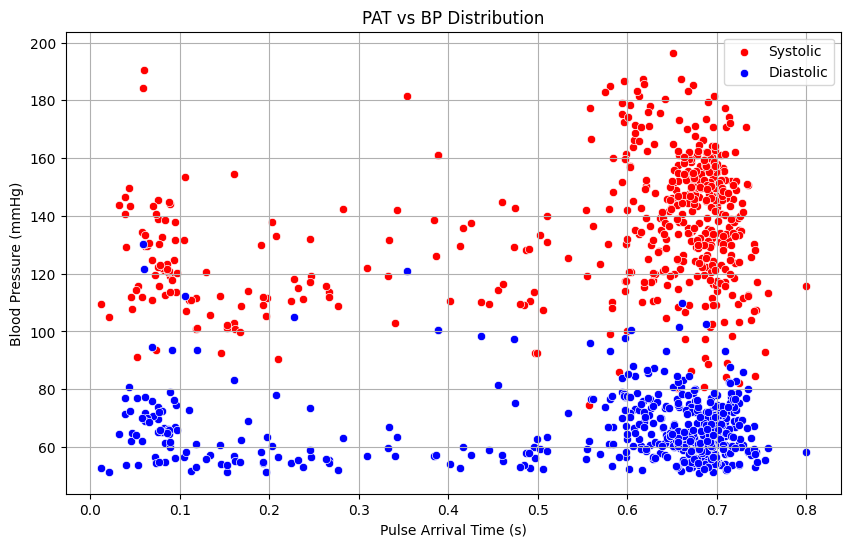

In [38]:
import seaborn as sns

# Create the scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="PAT (s)", y="Systolic BP", label="Systolic", color='r')
sns.scatterplot(data=df, x="PAT (s)", y="Diastolic BP", label="Diastolic", color='b')
plt.xlabel("Pulse Arrival Time (s)")
plt.ylabel("Blood Pressure (mmHg)")
plt.title("PAT vs BP Distribution")
plt.legend()
plt.grid(True)
plt.show()

In [39]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for the model
X = df[['PAT (s)']]
y_systolic = df['Systolic BP']
y_diastolic = df['Diastolic BP']

# Split the data into training and testing sets
X_train, X_test, y_systolic_train, y_systolic_test = train_test_split(X, y_systolic, test_size=0.2, random_state=42)
_, _, y_diastolic_train, y_diastolic_test = train_test_split(X, y_diastolic, test_size=0.2, random_state=42)

# Train a RandomForestRegressor for Systolic BP
model_systolic = RandomForestRegressor(n_estimators=100, random_state=42)
model_systolic.fit(X_train, y_systolic_train)

# Train a RandomForestRegressor for Diastolic BP
model_diastolic = RandomForestRegressor(n_estimators=100, random_state=42)
model_diastolic.fit(X_train, y_diastolic_train)

# Make predictions
y_systolic_pred = model_systolic.predict(X_test)
y_diastolic_pred = model_diastolic.predict(X_test)

# Evaluate the models
print("Systolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_systolic_test, y_systolic_pred):.2f}")
print(f"  R-squared: {r2_score(y_systolic_test, y_systolic_pred):.2f}")

print("\nDiastolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_diastolic_test, y_diastolic_pred):.2f}")
print(f"  R-squared: {r2_score(y_diastolic_test, y_diastolic_pred):.2f}")

Systolic BP Model Evaluation:
  Mean Squared Error: 811.83
  R-squared: -0.26

Diastolic BP Model Evaluation:
  Mean Squared Error: 150.46
  R-squared: -0.31


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare input and output
X = df[['PAT (s)']].values
y_systolic = df['Systolic BP'].values
y_diastolic = df['Diastolic BP'].values

# Split the data
X_train, X_test, y_systolic_train, y_systolic_test = train_test_split(X, y_systolic, test_size=0.2, random_state=42)
_, _, y_diastolic_train, y_diastolic_test = train_test_split(X, y_diastolic, test_size=0.2, random_state=42)

# Normalize the input (recommended for NN)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a function to build the neural network
def build_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train model for Systolic BP
model_systolic = build_model()
model_systolic.fit(X_train_scaled, y_systolic_train, epochs=100, verbose=0)

# Train model for Diastolic BP
model_diastolic = build_model()
model_diastolic.fit(X_train_scaled, y_diastolic_train, epochs=100, verbose=0)

# Predict
y_systolic_pred = model_systolic.predict(X_test_scaled).flatten()
y_diastolic_pred = model_diastolic.predict(X_test_scaled).flatten()

# Evaluate
print("Systolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_systolic_test, y_systolic_pred):.2f}")
print(f"  R-squared: {r2_score(y_systolic_test, y_systolic_pred):.2f}")

print("\nDiastolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_diastolic_test, y_diastolic_pred):.2f}")
print(f"  R-squared: {r2_score(y_diastolic_test, y_diastolic_pred):.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Systolic BP Model Evaluation:
  Mean Squared Error: 718.07
  R-squared: -0.12

Diastolic BP Model Evaluation:
  Mean Squared Error: 161.60
  R-squared: -0.41


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Features and targets
X = df[['PAT (s)']]
y_systolic = df['Systolic BP']
y_diastolic = df['Diastolic BP']

x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Split
X_train, X_test, y_systolic_train, y_systolic_test = train_test_split(X, y_systolic, test_size=0.2, random_state=42)
_, _, y_diastolic_train, y_diastolic_test = train_test_split(X, y_diastolic, test_size=0.2, random_state=42)

# Model architecture
def build_model():
    model = Sequential([
        Input(shape=(1,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train systolic model
model_systolic = build_model()
model_systolic.fit(X_train, y_systolic_train, epochs=100, verbose=0)

# Train diastolic model
model_diastolic = build_model()
model_diastolic.fit(X_train, y_diastolic_train, epochs=100, verbose=0)

# Predict
y_systolic_pred = model_systolic.predict(X_test).flatten()
y_diastolic_pred = model_diastolic.predict(X_test).flatten()

# Evaluate
print("Systolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_systolic_test, y_systolic_pred):.2f}")
print(f"  R-squared: {r2_score(y_systolic_test, y_systolic_pred):.2f}")

print("\nDiastolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_diastolic_test, y_diastolic_pred):.2f}")
print(f"  R-squared: {r2_score(y_diastolic_test, y_diastolic_pred):.2f}")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Systolic BP Model Evaluation:
  Mean Squared Error: 698.76
  R-squared: -0.09

Diastolic BP Model Evaluation:
  Mean Squared Error: 127.06
  R-squared: -0.11


In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Features and targets
X = df[['PAT (s)']].values
y_systolic = df[['Systolic BP']].values
y_diastolic = df[['Diastolic BP']].values

# Scaling
x_scaler = StandardScaler()
y_scaler_sys = StandardScaler()
y_scaler_dia = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_sys_scaled = y_scaler_sys.fit_transform(y_systolic)
y_dia_scaled = y_scaler_dia.fit_transform(y_diastolic)

# Split data
X_train, X_test, y_sys_train, y_sys_test = train_test_split(X_scaled, y_sys_scaled, test_size=0.2, random_state=42)
_, _, y_dia_train, y_dia_test = train_test_split(X_scaled, y_dia_scaled, test_size=0.2, random_state=42)

# Build model
def build_model():
    model = Sequential([
        Input(shape=(1,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train systolic model
model_sys = build_model()
model_sys.fit(X_train, y_sys_train, epochs=100, verbose=0)

# Train diastolic model
model_dia = build_model()
model_dia.fit(X_train, y_dia_train, epochs=100, verbose=0)

# Predict and inverse transform
y_sys_pred_scaled = model_sys.predict(X_test)
y_dia_pred_scaled = model_dia.predict(X_test)

y_sys_pred = y_scaler_sys.inverse_transform(y_sys_pred_scaled)
y_dia_pred = y_scaler_dia.inverse_transform(y_dia_pred_scaled)

y_sys_test_orig = y_scaler_sys.inverse_transform(y_sys_test)
y_dia_test_orig = y_scaler_dia.inverse_transform(y_dia_test)

# Evaluation
print("Systolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_sys_test_orig, y_sys_pred):.2f}")
print(f"  R-squared: {r2_score(y_sys_test_orig, y_sys_pred):.2f}")

print("\nDiastolic BP Model Evaluation:")
print(f"  Mean Squared Error: {mean_squared_error(y_dia_test_orig, y_dia_pred):.2f}")
print(f"  R-squared: {r2_score(y_dia_test_orig, y_dia_pred):.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Systolic BP Model Evaluation:
  Mean Squared Error: 570.98
  R-squared: 0.11

Diastolic BP Model Evaluation:
  Mean Squared Error: 119.22
  R-squared: -0.04
